### 📘 Model Training & Evaluation
**Goal:** Train and evaluate baseline machine-learning models for anomaly/fraud detection using the unified dataset.

**Author:** Dennis Fashimpaur
**Date:** 2025-11-26

This notebook performs:
* Loading the unified dataset
* Feature/label splitting
* Train/test split
* Training Logistic Regression
* Training Random Forest
* Standardization
* Compute precision, recall, F1, ROC-AUC
* Plot a confusion matrix
* Save trained models and evaluation results


### 🧭 Imports & Setup

In [12]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.data_loader import load_csv

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 150)

### 📊 Load Unified Dataset

In [13]:
unified_dataset = load_csv("../data/processed/unified_dataset.csv")
df = unified_dataset.copy()
print("🗄️ Loaded unified dataset with shape:", df.shape)
df.head()

🗄️ Loaded unified dataset with shape: (289967, 43)


,Amount,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9,amount,cat_fuel,cat_grocery,cat_pharmacy,cat_restaurant,cat_tech,cat_travel,customer_id,day_of_week,hour_of_day,status,time_since_last,timestamp,label
0,0.166322,0.913226,0.233487,0.681434,0.324081,-1.652084,0.974531,-1.019452,-0.425082,-0.174787,-0.318963,0.434814,-0.334869,-0.096506,0.118613,0.115522,-0.017332,0.076978,0.053263,1.104557,-0.322679,-0.205898,-1.131863,0.338485,-0.026602,-0.776100,0.374496,-0.209822,0.288196,0.0,0,0,0,0,0,0,217390.0,0,15,0,0.0,2023-01-02 15:07:52,0
1,-0.313289,-0.343731,-0.425360,0.102995,0.361722,0.346380,0.179415,1.105441,-0.365223,-0.103334,-0.915612,-0.690663,0.690284,-0.128852,-0.095639,-0.325158,0.014393,0.592538,-0.445124,-1.398906,0.018693,0.361152,1.226153,0.324928,0.103641,-0.335388,0.645968,-0.036795,-0.586683,0.0,0,0,0,0,0,0,41818.0,6,11,0,0.0,2023-01-01 11:20:41,0
2,-0.133734,0.575680,0.030164,1.473301,1.214818,0.488987,0.624722,0.314802,0.011253,-0.433739,-0.928824,0.178007,0.069638,0.022346,-0.396476,-1.323322,0.120628,-0.482128,0.433655,0.339656,-0.142786,0.006433,-0.087418,0.226253,0.156094,-0.181979,0.268919,-0.047594,-0.463394,0.0,0,0,0,0,0,0,14846.0,6,7,0,0.0,2023-01-01 07:15:25,0
3,-0.051774,0.946089,-0.186512,1.042947,0.335203,-1.089894,-0.665695,-1.027357,0.000233,0.952234,0.737060,-0.212151,0.129488,-0.161349,0.065360,0.166529,-0.079623,0.932803,0.760832,-1.134084,-0.055540,-0.065773,-1.568283,1.014384,0.661101,-0.490287,0.493573,-0.139013,-0.033381,0.0,0,0,0,0,0,0,249264.0,0,18,0,0.0,2023-01-02 18:52:03,0
4,0.536345,-0.309597,0.707002,2.101898,0.319726,-0.773983,-0.426621,1.905974,-2.173136,1.056852,-1.217150,0.215612,0.127405,-0.116030,0.299150,2.216266,-0.301771,-1.608641,-1.746136,-0.166051,-1.086910,-1.644091,1.201845,0.860543,-0.113263,2.167935,0.894818,-0.106611,0.273161,0.0,0,0,0,0,0,0,69844.0,6,14,0,0.0,2023-01-01 14:53:27,0


### ䷖ Split Features & Labels
We remove the `label` column (fraud indicator) and keep only numeric features for modeling.

In [14]:
X = df.drop(columns=['label'])
X = X.select_dtypes(include=['number'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (231973, 41)
Test shape: (57994, 41)


### 🔧 Standardize Features (for Logistic Regression)

In [15]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

### 💡 Evaluation Helper

In [16]:
def evaluate_model(y_test, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }

### 📈 Logistic Regression — Train

In [17]:
logreg = LogisticRegression(solver="lbfgs", max_iter=2000)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

### 📈 Logistic Regression — Evaluate

In [18]:
lr_metrics = evaluate_model(y_test, y_pred_lr, y_prob_lr)
pd.DataFrame([lr_metrics])

,accuracy,precision,recall,f1,roc_auc
0,0.999328,0.940299,0.642857,0.763636,0.992692


### 🧩 Confusion Matrix — Logistic Regression

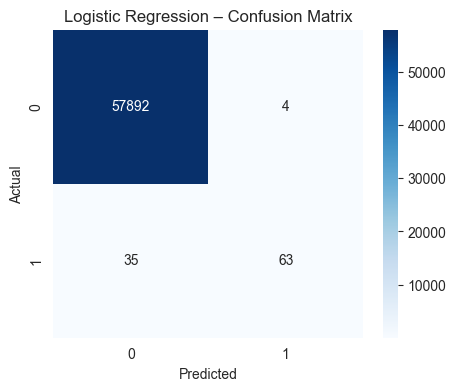

In [19]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 🌲 Random Forest — Train

In [20]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

### 🌲 Random Forest — Evaluate

In [21]:
rf_metrics = evaluate_model(y_test, y_pred_rf, y_prob_rf)
pd.DataFrame([rf_metrics])

,accuracy,precision,recall,f1,roc_auc
0,0.999638,0.963855,0.816327,0.883978,0.989304


### 🆚 Model Comparison

In [22]:
comparison = pd.DataFrame([
    {"model": "Logistic Regression", **lr_metrics},
    {"model": "Random Forest", **rf_metrics}
])
comparison

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.999328,0.940299,0.642857,0.763636,0.992692
1,Random Forest,0.999638,0.963855,0.816327,0.883978,0.989304


### 💾 Save Models & Evaluation Results

In [23]:
os.makedirs("../data/models", exist_ok=True)
os.makedirs("../data/results", exist_ok=True)

# Save models
joblib.dump(logreg, "../data/models/logistic_regression.pkl")
joblib.dump(rf, "../data/models/random_forest.pkl")

print("💿 Saved logistic regression to data/models/logistic_regression.pkl")
print("💿 Saved random forest to data/models/random_forest.pkl")

# Save metrics
comparison.to_csv("../data/results/model_results.csv", index=False)
print("💿 Saved model results to data/results/model_results.csv")

💿 Saved logistic regression to data/models/logistic_regression.pkl
💿 Saved random forest to data/models/random_forest.pkl
💿 Saved model results to data/results/model_results.csv
